In [ ]:
import os
os.environ["_DEBUG"] = "1"
os.environ["_MULTIPROCESS"] = "0"

# Star notation allows importing type hints for kedro variables (catalog, pipeline, etc)
# along with the register_kedro function.
from pasteur.kedro.ipython import *
from pasteur.utils.styles import use_style

# Import data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add autoreload to allow iterating on your modules
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

# Register your kedro project to access the catalog
register_kedro()
use_style('mlflow')

In [ ]:
m = catalog.load("tab_adult.privbayes.model")

In [ ]:
import networkx as nx

In [ ]:
# base = {
#     "font_size": 12,
#     "node_size": 700,
#     "width": 2,
#     "fill": "white",
#     "stroke": "black",
# }


# options = {
#     "font_size": base["font_size"],
#     "node_size": base["node_size"],
#     "linewidths": base["width"],
#     "width": base["width"],
#     # "node_color": base['fill'],
#     # "edgecolors": base['stroke'],
#     "node_shape": "",
#     "with_labels": True,
#     "bbox": {
#         "boxstyle": "round",
#         "facecolor": base["fill"],
#         "edgecolor": base["stroke"],
#         "linewidth": base["width"],
#     },
#     "margins": (0.2, 0),
# }

In [ ]:
# pos = {}
# j = [0, -1, 1]
# for i, ns in enumerate(nx.topological_generations(g)):
#     for k, n in enumerate(ns):
#         y = -i + k / len(ns) - 0.4
#         pre = list(g.predecessors(n))
#         if i < len(j):
#             x = j[i]
#         else:
#             x = sum(pos[c][0] for c in pre) / len(pre)
#         pos[n] = (x, y)

# pos_og = pos
# names = list(pos)
# pos_x = [x for x, _ in pos.values()]
# pos_x = np.argsort(np.argsort(pos_x))
# pos_y = [y for _, y in pos.values()]
# pos = {n: (x, y) for n, x, y in zip(names, pos_x, pos_y)}


# height = base['font_size'] * 6 * (i + 1) / 72
# plt.figure(figsize=(7, height))
# nx.draw(g, pos, **options)

In [ ]:
from IPython.core.display import SVG


def display_graph(g, prog="neato", graph={}, nodes={}, edges={}):
    process_args = lambda args, pref: [f"{pref}{k}={v}" for k, v in args.items()]
    args = (
        process_args(graph, "-G")
        + process_args(edges, "-E")
        + process_args(nodes, "-N")
    )

    display(SVG(nx.nx_pydot.to_pydot(g).create(format="svg", prog=[prog, *args])))

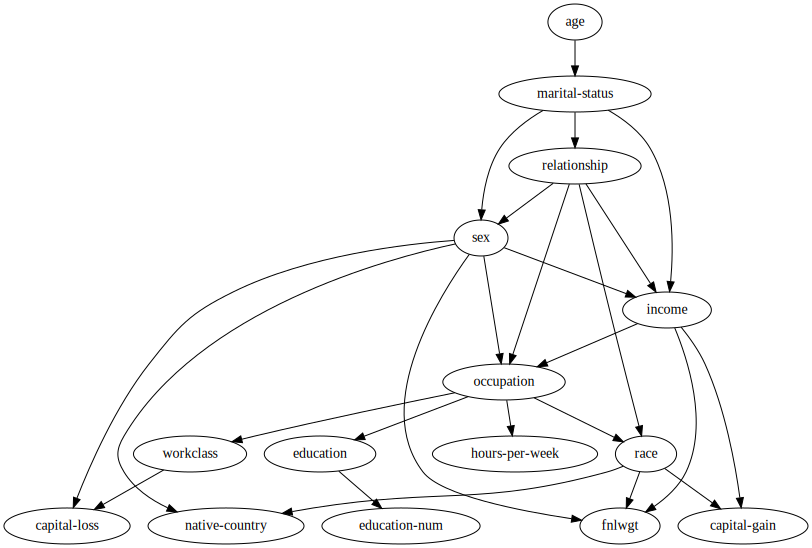

In [ ]:
g = nx.DiGraph()
commons = {}

for i, n in enumerate(m.nodes):
    g.add_node(n.value, attr=n.attr, order=i)
    if n.attr != n.value:
        commons[n.attr] = n.value
    for p in n.p:
        c = p[-1]
        if isinstance(c, int):
            g.add_edge(commons[p[-2]], n.value)
        else:
            for v in p[-1]:
                g.add_edge(v, n.value)

display_graph(g, "dot", graph={"ratio": "compress"})